In [15]:
from transformers import AutoTokenizer
import mlx.core as mx
import mlx_lm
import json
import time

# MLX 모델 로드 (Gemma 3 기반)
model_path = "mlx-community/gemma-3-12b-it-qat-4bit"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = mlx_lm.load(model_path)
except OSError:
    # 로컬 경로에서 시도
    print("허깅페이스에서 모델을 찾을 수 없습니다. 로컬 경로에서 로드를 시도합니다.")
    tokenizer = AutoTokenizer.from_pretrained("./gemma-3-12b-it-qat-4bit")
    model = mlx_lm.load("./gemma-3-12b-it-qat-4bit")




Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [9]:
from transformers import AutoTokenizer
import mlx.core as mx
import mlx_lm
import json
import time
def classify_review(review_text):
    prompt = f"""
다음은 음악 평론이다. 이 평론에 대해 아래 9가지 항목의 언급 여부를 판단해줘. 각 항목은 언급되면 1, 언급되지 않으면 0으로 표시해줘:

1. 가사 관련 언급 (lyrics_mentioned): 노래 가사의 내용, 의미, 품질에 대한 언급
2. 아티스트의 삶 또는 개인사 관련 언급 (artist_context): 음악가의 배경, 경력, 개인적 이야기에 대한 언급
3. 장르적 맥락 언급 (genre_context): 음악 장르나 스타일에 대한 설명이나 분석
4. 사운드/프로덕션 분석 (sound_or_production): 음향, 믹싱, 악기 사용, 프로덕션 기법에 대한 분석
5. 음악사적 위치 언급 (historical_context): 음악의 역사적 맥락이나 중요성에 대한 언급
6. 문화/사회적 의미 언급 (cultural_or_social_commentary): 음악이 가진 사회적, 문화적 의미나 영향력에 대한 논의
7. 감정적 반응 묘사 (emotional_response): 평론가나 청취자의 감정적 반응이나 느낌에 대한 묘사
8. 타 아티스트/작품과의 비교나 참조 (reference_or_comparison): 다른 음악가나 작품과의 비교 또는 참조
9. 명시적 평가적 표현 (explicit_evaluation): 작품의 가치나 품질에 대한 직접적인 평가 표현

반드시 아래 형식의 JSON으로만 답변해주세요. 다른 설명이나 텍스트는 포함하지 마세요:
{{
  "lyrics_mentioned": 0 또는 1,
  "artist_context": 0 또는 1,
  "genre_context": 0 또는 1,
  "sound_or_production": 0 또는 1,
  "historical_context": 0 또는 1,
  "cultural_or_social_commentary": 0 또는 1,
  "emotional_response": 0 또는 1,
  "reference_or_comparison": 0 또는 1,
  "explicit_evaluation": 0 또는 1
}}

평론:
\"\"\"{review_text}\"\"\"
"""

    # 전역 변수 확인 및 모델 로드 상태 확인
    global tokenizer, model
    
    # 모델 로드 확인 및 필요시 재로드
    try:
        # 모델이 없는 경우 재로드
        if model is None:
            print("모델을 로드합니다...")
            model_path = "mlx-community/gemma-3-12b-it-qat-4bit"
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model,_ = mlx_lm.load(model_path)
                print(type(model))
                print("모델이 성공적으로 로드되었습니다.")
            except Exception as e:
                print(f"온라인 모델 로드 실패: {str(e)}, 로컬 경로에서 시도합니다.")
                tokenizer = AutoTokenizer.from_pretrained("./gemma-3-12b-it-qat-4bit")
                model,_ = mlx_lm.load("./gemma-3-12b-it-qat-4bit")
                print("모델이 로컬 경로에서 성공적으로 로드되었습니다.")
        
        # 메시지 형식으로 변환
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True
        )
        
        # 모델 생성 실행
        response_text = mlx_lm.generate(model, tokenizer, prompt=formatted_prompt, max_tokens=128, verbose=True)
        print(response_text)
        # JSON 부분만 추출하기 위한 처리
        import re
        json_match = re.search(r'\{[\s\S]*\}', response_text)
        if json_match:
            json_str = json_match.group(0)
            # JSON 파싱 시도
            try:
                json_data = json.loads(json_str)
                return json_str
            except:
                return json_str
        else:
            return response_text
            
    except Exception as e:
        print(f"처리 중 오류 발생: {str(e)}")
        # 기본 응답 반환
        return json.dumps({
            "lyrics_mentioned": 0,
            "artist_context": 0,
            "genre_context": 0,
            "sound_or_production": 0,
            "historical_context": 0,
            "cultural_or_social_commentary": 0,
            "emotional_response": 0,
            "reference_or_comparison": 0,
            "explicit_evaluation": 0
        })

# 데이터셋 로드
try:
    with open("dataset/pitchfork_reviews.json", "r", encoding="utf-8") as f:
        reviews_data = json.load(f)
except Exception as e:
    print(f"데이터셋 로드 오류: {str(e)}")
    reviews_data = []

# 모든 리뷰에 대해 분류 실행
results = []
total_reviews = len(reviews_data)

# 모델 초기화 확인
try:
    if 'model' not in globals() or model is None:
        print("모델을 초기화합니다...")
        model_path = "mlx-community/gemma-3-12b-it-qat-4bit"
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model,_ = mlx_lm.load(model_path)
            print("모델이 성공적으로 초기화되었습니다.")
        except Exception as e:
            print(f"온라인 모델 로드 실패: {str(e)}, 로컬 경로에서 시도합니다.")
            tokenizer = AutoTokenizer.from_pretrained("./gemma-3-12b-it-qat-4bit")
            model,_ = mlx_lm.load("./gemma-3-12b-it-qat-4bit")
            print("모델이 로컬 경로에서 성공적으로 초기화되었습니다.")
except Exception as e:
    print(f"모델 초기화 오류: {str(e)}")

print(type(model))
# model 이 튜플이면 처리
if isinstance(model, tuple):
    model = model[0]


for i, review in enumerate(reviews_data):
    print(f"처리 중: {i+1}/{total_reviews} ({(i+1)/total_reviews*100:.2f}%)")
    try:
        # 데이터 구조 확인 및 수정
        if "review" in review and isinstance(review["review"], str):
            review_text = review["review"]
        elif "text" in review and isinstance(review["text"], str):
            review_text = review["text"]
        elif "review_text" in review and isinstance(review["review_text"], str):
            review_text = review["review_text"]
        else:
            # 리뷰 텍스트를 찾을 수 없는 경우 키 확인
            available_keys = list(review.keys())
            for key in available_keys:
                if isinstance(review[key], str) and len(review[key]) > 100:  # 텍스트로 보이는 긴 문자열 필드 찾기
                    review_text = review[key]
                    print(f"리뷰 텍스트로 '{key}' 필드를 사용합니다.")
                    break
            else:
                raise KeyError(f"리뷰 텍스트를 찾을 수 없습니다. 사용 가능한 키: {available_keys}")
        
        classification = classify_review(review_text)
        
        # 결과 저장
        result = {
            "review_id": review.get("id", i),
            "classification": classification,
            "review_text": review_text[:500] + "..." if len(review_text) > 500 else review_text  # 저장 공간 절약을 위해 텍스트 줄임
        }
        results.append(result)
        
        # 매 리뷰마다 개별 JSON 파일 저장
        with open(f"classification_result_{i}.json", "w", encoding="utf-8") as f:
            json.dump(result, f, ensure_ascii=False, indent=2)
        
        # 진행 상황 저장 (10개마다)
        if (i + 1) % 10 == 0:
            with open(f"classification_results_{i+1}.json", "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=2)
                
        # API 제한 방지를 위한 짧은 대기
        time.sleep(0.5)
        
    except Exception as e:
        print(f"오류 발생 (리뷰 {i}): {str(e)}")
        # 오류 발생 시에도 결과 저장
        if (i + 1) % 50 == 0:
            with open(f"classification_results_error_{i+1}.json", "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=2)
        continue

# 최종 결과 저장
with open("classification_results_final.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"총 {len(results)}/{total_reviews} 리뷰 처리 완료")

<class 'mlx_lm.models.gemma3.Model'>
처리 중: 1/480 (0.21%)
```json
{
  "lyrics_mentioned": 0,
  "artist_context": 1,
  "genre_context": 1,
  "sound_or_production": 1,
  "historical_context": 1,
  "cultural_or_social_commentary": 1,
  "emotional_response": 1,
  "reference_or_comparison": 1,
  "explicit_evaluation": 1
}
```<end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn><end_of_turn>
Prompt: 1132 tokens, 253.608 tokens-per-sec
Generation: 128 tokens, 31.664 tokens-per-sec
Peak memory: 10.291 GB
```json
{
  "lyrics_mentioned": 0,
  "artist_context": 1,
  "genre_context": 1,
  "sound_or_production": 1,
  "historical_context": 1,
  "cultural_or_social_commentary": 1,
  "emotional_response": 1,
  "reference_or_comparison": 1,
  "explicit_evaluation": 1
}
```<end_of_turn><e

In [11]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.9 MB/s eta 0:00:00 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 47.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.4 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


각 분류 항목별 카운트:
lyrics_mentioned: 1 = 305개, 0 = 175개
artist_context: 1 = 456개, 0 = 24개
genre_context: 1 = 447개, 0 = 33개
sound_or_production: 1 = 458개, 0 = 22개
historical_context: 1 = 252개, 0 = 228개
cultural_or_social_commentary: 1 = 289개, 0 = 191개
emotional_response: 1 = 464개, 0 = 16개
reference_or_comparison: 1 = 467개, 0 = 13개
explicit_evaluation: 1 = 448개, 0 = 32개


/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  fig.tight_layout()
/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  fig.tight_layout()
/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) Arial.
  fig.tight_layout()
/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) Arial.
  fig.tight_layout()
/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) Arial.
  fig.tight_layout()
/var/folders/94/3q8h58fs4vn5_41wv5bycztc0000gn/T/ipykernel_33793/2154653136.py:80: UserW

<Figure size 1400x800 with 0 Axes>

/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50500 (\N{HANGUL SYLLAB

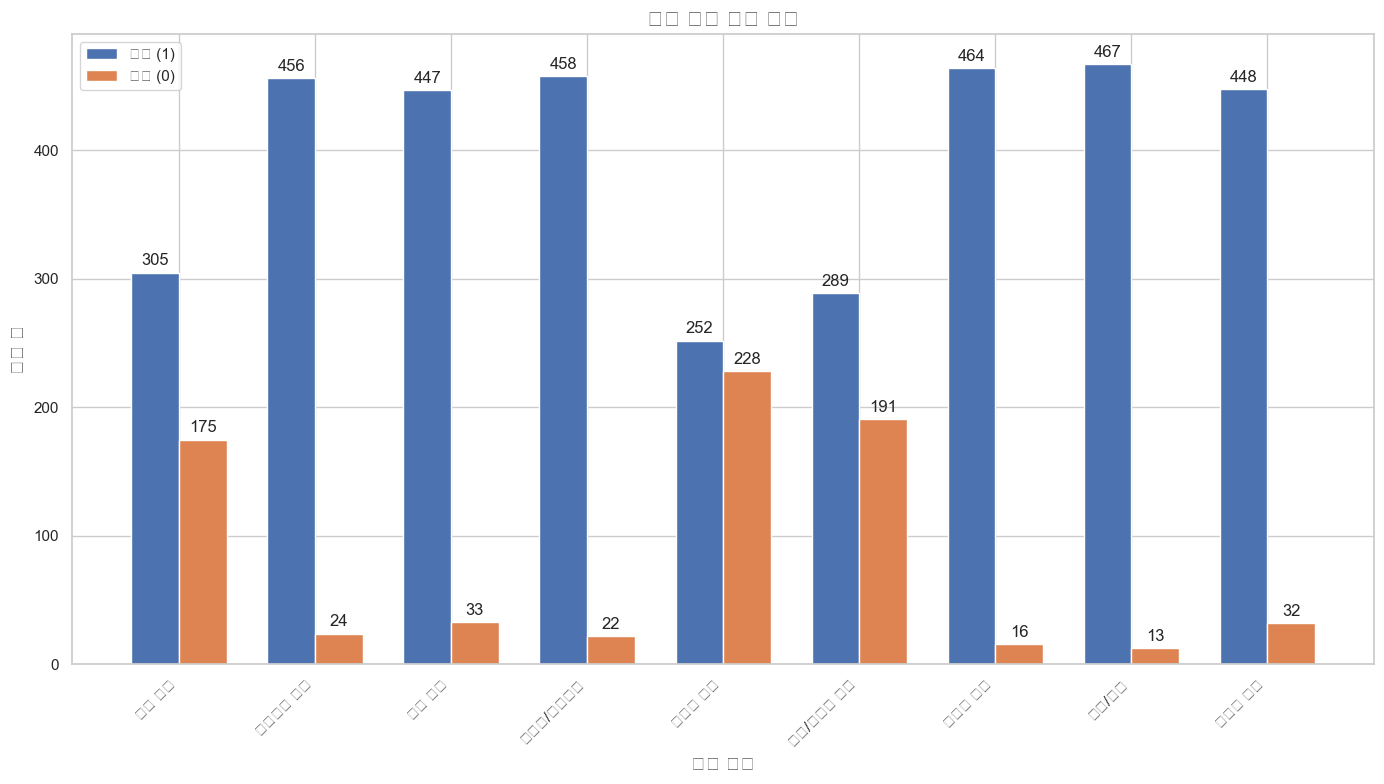

/opt/homebrew/anaconda3/envs/qwen/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


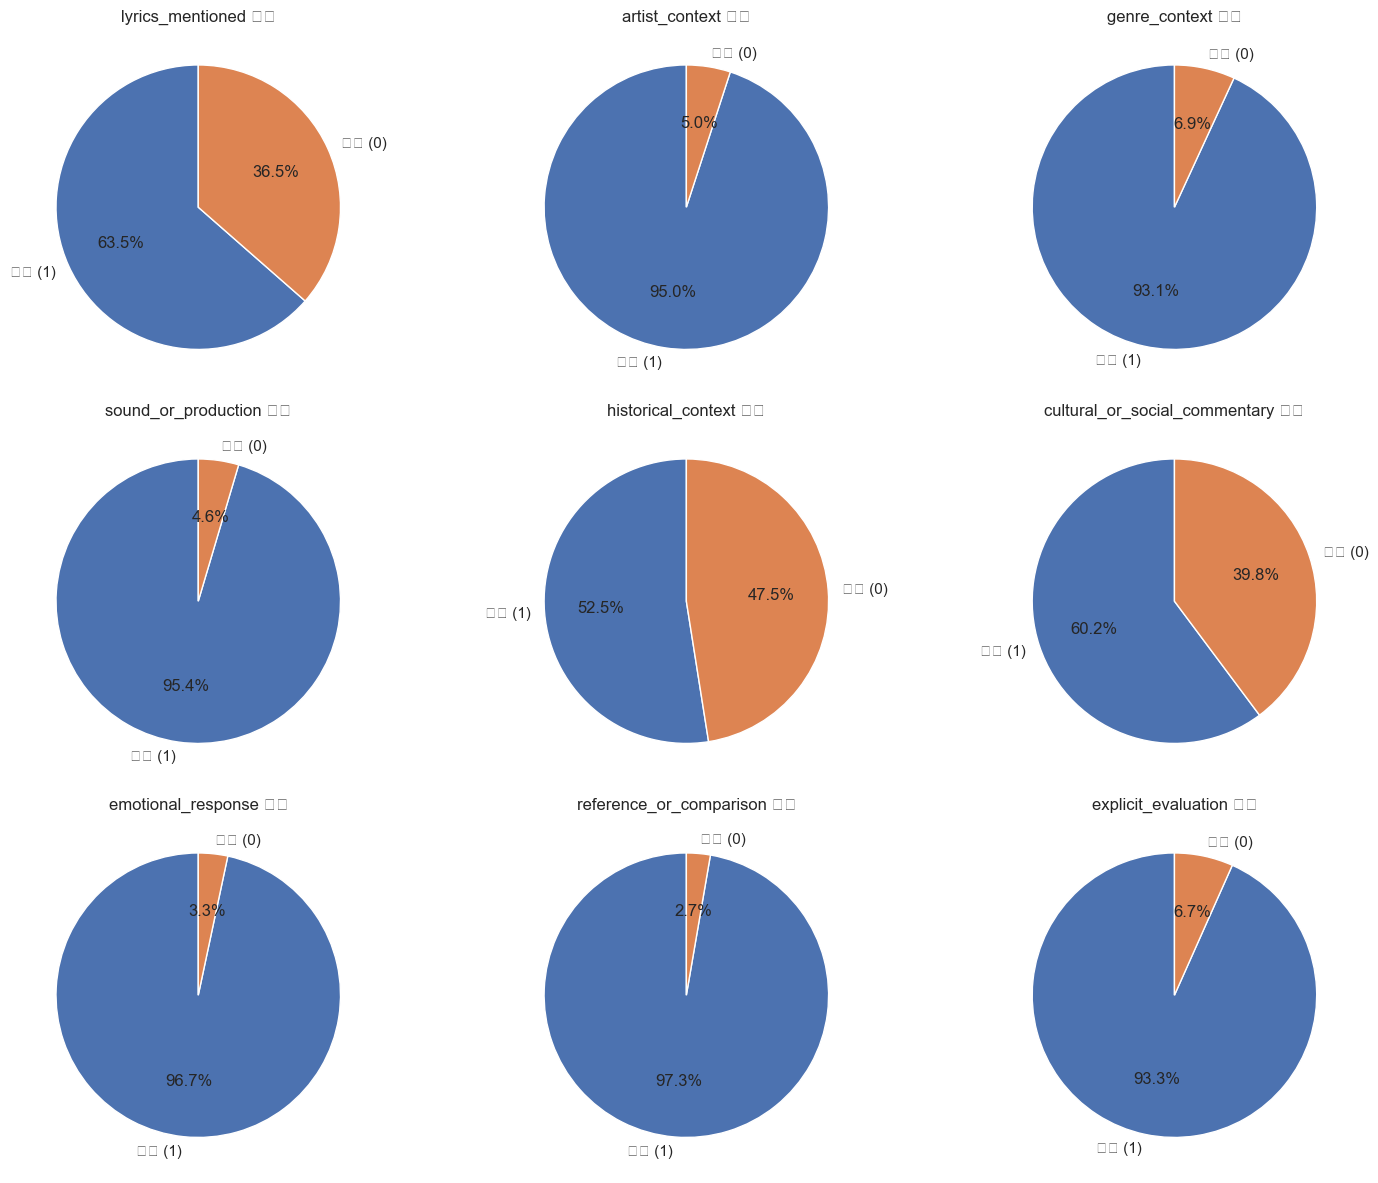

In [12]:
# 분류 결과 시각화하기
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np

# JSON 파일 로드
with open("classification_results_480.json", "r", encoding="utf-8") as f:
    reviews = json.load(f)

# 분류 결과를 저장할 데이터프레임 생성
classification_data = []

# 각 리뷰의 분류 결과 파싱
for review in reviews:
    try:
        # 문자열 형태의 JSON을 파이썬 딕셔너리로 변환
        classification = json.loads(review["classification"])
        classification["review_id"] = review["review_id"]
        classification_data.append(classification)
    except Exception as e:
        print(f"리뷰 {review['review_id']} 처리 중 오류 발생: {str(e)}")

# 데이터프레임 생성
df = pd.DataFrame(classification_data)

# 각 분류 항목별 카운트 계산
category_counts = {}
for column in df.columns:
    if column != "review_id":
        category_counts[column] = df[column].value_counts().to_dict()

# 결과 출력
print("각 분류 항목별 카운트:")
for category, counts in category_counts.items():
    print(f"{category}: 1 = {counts.get(1, 0)}개, 0 = {counts.get(0, 0)}개")

# 시각화
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# 각 카테고리별 1과 0의 개수를 바 차트로 표시
categories = [col for col in df.columns if col != "review_id"]
ones = [df[category].value_counts().get(1, 0) for category in categories]
zeros = [df[category].value_counts().get(0, 0) for category in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ones, width, label='있음 (1)')
rects2 = ax.bar(x + width/2, zeros, width, label='없음 (0)')

# 그래프 꾸미기
ax.set_title('음악 리뷰 분류 결과', fontsize=16)
ax.set_xlabel('분류 항목', fontsize=14)
ax.set_ylabel('리뷰 수', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([
    '가사 언급', '아티스트 맥락', '장르 맥락', '사운드/프로덕션', 
    '역사적 맥락', '문화/사회적 논평', '감정적 반응', 
    '참조/비교', '명시적 평가'
], rotation=45, ha='right')
ax.legend()

# 막대 위에 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 수직 오프셋
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# 파이 차트로 각 카테고리별 비율 시각화
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
    plt.subplot(3, 3, i+1)
    counts = df[category].value_counts()
    labels = ['있음 (1)', '없음 (0)']
    sizes = [counts.get(1, 0), counts.get(0, 0)]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'{category} 비율')

plt.tight_layout()
plt.show()
